# Towards Total Recall in Industrial Anomaly Detection

- **Author**: Jaehyuk Heo
- **Paper**: https://arxiv.org/pdf/2106.08265.pdf
- **Github**: https://github.com/amazon-research/patchcore-inspection


**장점**
- 학습 안해서 학습 시간 없음

**단점**
- similarity 연산량이 너무 큼

![image](https://user-images.githubusercontent.com/37654013/179403914-856cf062-056e-49ab-8dad-b1d0f70932c5.png)

In [150]:
%reload_ext autoreload
%autoreload 2

import contextlib

import torch
import common
import sampler
import patchcore
import backbones
import metrics
import utils

from dataset import MVTecDataset, DatasetSplit, IMAGENET_MEAN, IMAGENET_STD

import torch.nn.functional as F
from tqdm.auto import tqdm
import numpy as np
from typing import Union, List

import matplotlib.pyplot as plt
import os

# DataLoader

![image](https://user-images.githubusercontent.com/37654013/179403845-8aedf36d-bd35-4b1d-a1f4-21d8154ee2ce.png)


In [2]:
def create_dataloader(
    data_path,
    subdataset,
    train_val_split,
    batch_size,
    resize,
    imagesize,
    num_workers
):
        
    train_dataset = MVTecDataset(
        data_path,
        classname       = subdataset,
        resize          = resize,
        train_val_split = train_val_split,
        imagesize       = imagesize,
        split           = DatasetSplit.TRAIN
    )

    test_dataset = MVTecDataset(
        data_path,
        classname = subdataset,
        resize    = resize,
        imagesize = imagesize,
        split     = DatasetSplit.TEST
    )

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size  = batch_size,
        shuffle     = False,
        num_workers = num_workers,
        pin_memory  = True,
    )

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size  = batch_size,
        shuffle     = False,
        num_workers = num_workers,
        pin_memory  = True,
    )

    return train_dataloader, test_dataloader

In [3]:
train_dataloader, test_dataloader = create_dataloader(
    data_path       = '/datasets/MVTec',
    subdataset      = 'bottle',
    train_val_split = 1.,
    batch_size      = 2,
    resize          = 256, 
    imagesize       = 224,
    num_workers     = 8
)

In [4]:
train_dataloader.dataset[0]

{'image': tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.64

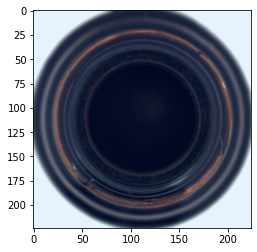

In [5]:
img = train_dataloader.dataset[0]['image'].permute(1,2,0)
img = (img - img.min()) / (img.max() - img.min())
plt.imshow(img)

# Model

In [6]:
device = utils.set_torch_device(gpu_ids=[0])

In [7]:
patch_core = patchcore.PatchCore(device)

In [8]:
patch_core.load(
    backbone                 = backbones.load('wideresnet50'),
    layers_to_extract_from   = ['layer4'],
    device                   = device,
    input_shape              = train_dataloader.dataset.imagesize,
    pretrain_embed_dimension = 1024,
    target_embed_dimension   = 1024,
    patchsize                = 3,
    anomaly_scorer_num_nn    = 5,
    featuresampler           = sampler.GreedyCoresetSampler(percentage=0.1, device=device),
    nn_method                = common.FaissNN(on_gpu=False, num_workers=8)
)

# Sample Images

In [9]:
batch_temp = next(iter(train_dataloader))

In [10]:
images = batch_temp['image']
images = images.to(torch.float).to(patch_core.device)

print('images.size: ',images.size())

images.size:  torch.Size([2, 3, 224, 224])


# Fitting

![image](https://user-images.githubusercontent.com/37654013/179403963-399048d4-5739-40c8-96ac-279026d6a889.png)


## 1. Extract Features

![image](https://user-images.githubusercontent.com/37654013/179403999-d7acbd2d-f430-45f3-8766-faddbf9d1b96.png)

In [11]:
def _detach(features):
    if detach:
        return [x.detach().cpu().numpy() for x in features]
    return features

In [12]:
_ = patch_core.forward_modules["feature_aggregator"].eval()

with torch.no_grad():
    features = patch_core.forward_modules["feature_aggregator"](images)

In [13]:
print('layer list: ',features.keys())
print("features['layer4'].size(): ",features['layer4'].size())

layer list:  dict_keys(['layer4'])
features['layer4'].size():  torch.Size([2, 2048, 7, 7])


## 2. Patchfying

![image](https://user-images.githubusercontent.com/37654013/179404021-540edd78-0f4f-4d07-9c47-8c11d221c7d3.png)

In [14]:
# extract features from selected layers
features = [features[layer] for layer in patch_core.layers_to_extract_from]

# patchfying features
features = [
    patch_core.patch_maker.patchify(x, return_spatial_info=True) for x in features
]

In [15]:
# batch
print("len(features): ",len(features))

# features with number of total patches
print("len(features[0]): ",len(features[0]))

len(features):  1
len(features[0]):  2


In [16]:
# unfold results
print("features[0][0].size(): ",features[0][0].size())

# number of total patches
print('features[0][1]: ',features[0][1])

features[0][0].size():  torch.Size([2, 49, 2048, 3, 3])
features[0][1]:  [7, 7]


In [17]:
patch_shapes = [x[1] for x in features]
features = [x[0] for x in features]
ref_num_patches = patch_shapes[0]

In [18]:
print('patch_shapes: ',patch_shapes)

patch_shapes:  [[7, 7]]


In [19]:
for i in range(1, len(features)):
    _features = features[i]
    patch_dims = patch_shapes[i]

    # TODO(pgehler): Add comments
    
    # _features = (Batch size x feature map height x feature map width x channels x patch height x patch width)
    _features = _features.reshape(
        _features.shape[0], patch_dims[0], patch_dims[1], *_features.shape[2:]
    )
    
    # _features = (Batch size x channels x patch height x patch width x feature map height x feature map width)
    _features = _features.permute(0, -3, -2, -1, 1, 2)
    perm_base_shape = _features.shape

    # _features = ((Batch size x channels x patch height x patch width) x feature map height x feature map width)        
    _features = _features.reshape(-1, *_features.shape[-2:])
    
    # _features = ((Batch size x channels x patch height x patch width) x 1 x ref height x ref width)
    _features = F.interpolate(
        _features.unsqueeze(1),
        size=(ref_num_patches[0], ref_num_patches[1]),
        mode="bilinear",
        align_corners=False,
    )
    
    _features = _features.squeeze(1)
    
    # _features = (Batch size x channels x patch height x patch width x ref height x ref width)
    _features = _features.reshape(
        *perm_base_shape[:-2], ref_num_patches[0], ref_num_patches[1]
    )
    
    # _features = (Batch size x ref height x ref width x channels x patch height x patch width)
    _features = _features.permute(0, -2, -1, 1, 2, 3)
    
    # _features = (Batch size x (ref height x ref width) x channels x patch height x patch width)
    _features = _features.reshape(len(_features), -1, *_features.shape[-3:])
    features[i] = _features
    
    
# _features = ((Batch size x (ref height x ref width)) x channels x patch height x patch width)
features = [x.reshape(-1, *x.shape[-3:]) for x in features]

In [20]:
print('features[0].shape: ',features[0].shape)
# print('features[1].shape: ',features[1].shape)

features[0].shape:  torch.Size([98, 2048, 3, 3])


## 3. Aggregation

In [21]:
# ========================
# preprocessing
# ========================
class Preprocessing(torch.nn.Module):
    def __init__(self, input_dims, output_dim):
        super(Preprocessing, self).__init__()
        self.input_dims = input_dims
        self.output_dim = output_dim

        self.preprocessing_modules = torch.nn.ModuleList()
        for input_dim in input_dims:
            module = MeanMapper(output_dim)
            self.preprocessing_modules.append(module)

    def forward(self, features):
        _features = []
        for module, feature in zip(self.preprocessing_modules, features):
            _features.append(module(feature))
        return torch.stack(_features, dim=1)


class MeanMapper(torch.nn.Module):
    def __init__(self, preprocessing_dim):
        super(MeanMapper, self).__init__()
        self.preprocessing_dim = preprocessing_dim

    def forward(self, features):
        features = features.reshape(len(features), 1, -1)
        return F.adaptive_avg_pool1d(features, self.preprocessing_dim).squeeze(1)
    
# ========================
# preadapt_aggregator
# ========================
class Aggregator(torch.nn.Module):
    def __init__(self, target_dim):
        super(Aggregator, self).__init__()
        self.target_dim = target_dim

    def forward(self, features):
        """Returns reshaped and average pooled features."""
        # batchsize x number_of_layers x input_dim -> batchsize x target_dim
        features = features.reshape(len(features), 1, -1)
        features = F.adaptive_avg_pool1d(features, self.target_dim)
        return features.reshape(len(features), -1)

In [22]:
features = patch_core.forward_modules["preprocessing"](features)

In [23]:
print('features.size(): ',features.size())

features.size():  torch.Size([98, 1, 1024])


In [24]:
features = patch_core.forward_modules["preadapt_aggregator"](features)

In [25]:
print('features.size(): ',features.size())

features.size():  torch.Size([98, 1024])


## 1 ~ 3. Apply total train data

In [26]:
_ = patch_core.forward_modules.eval()

def _image_to_features(input_image):
    with torch.no_grad():
        input_image = input_image.to(torch.float).to(patch_core.device)
        return patch_core._embed(input_image)

features = []
with tqdm(
    train_dataloader, desc="Computing support features...", position=1, leave=False
) as data_iterator:
    for image in data_iterator:
        if isinstance(image, dict):
            image = image["image"]
        features.append(_image_to_features(image))

features = np.concatenate(features, axis=0)

In [27]:
print('features.shape: ',features.shape)

features.shape:  (10241, 1024)


## 4. Sampler

![image](https://user-images.githubusercontent.com/37654013/179404044-e01356a4-3277-4217-9f74-075c18292c6c.png)

In [28]:
class GreedyCoresetSampler(sampler.BaseSampler):
    def __init__(
        self,
        percentage: float,
        device: torch.device,
        dimension_to_project_features_to=128,
    ):
        """Greedy Coreset sampling base class."""
        super().__init__(percentage)

        self.device = device
        self.dimension_to_project_features_to = dimension_to_project_features_to

    def _reduce_features(self, features):
        if features.shape[1] == self.dimension_to_project_features_to:
            return features
        mapper = torch.nn.Linear(
            features.shape[1], self.dimension_to_project_features_to, bias=False
        )
        _ = mapper.to(self.device)
        features = features.to(self.device)
        return mapper(features)

    def run(
        self, features: Union[torch.Tensor, np.ndarray]
    ) -> Union[torch.Tensor, np.ndarray]:
        """Subsamples features using Greedy Coreset.
        Args:
            features: [N x D]
        """
        if self.percentage == 1:
            return features
        self._store_type(features)
        if isinstance(features, np.ndarray):
            features = torch.from_numpy(features)
        reduced_features = self._reduce_features(features)
        sample_indices = self._compute_greedy_coreset_indices(reduced_features)
        features = features[sample_indices]
        return self._restore_type(features)

    @staticmethod
    def _compute_batchwise_differences(
        matrix_a: torch.Tensor, matrix_b: torch.Tensor
    ) -> torch.Tensor:
        """Computes batchwise Euclidean distances using PyTorch."""
        a_times_a = matrix_a.unsqueeze(1).bmm(matrix_a.unsqueeze(2)).reshape(-1, 1)
        b_times_b = matrix_b.unsqueeze(1).bmm(matrix_b.unsqueeze(2)).reshape(1, -1)
        a_times_b = matrix_a.mm(matrix_b.T)

        return (-2 * a_times_b + a_times_a + b_times_b).clamp(0, None).sqrt()

    def _compute_greedy_coreset_indices(self, features: torch.Tensor) -> np.ndarray:
        """Runs iterative greedy coreset selection.
        Args:
            features: [NxD] input feature bank to sample.
        """
        # distance_matrix = ((batch size x ref height x ref width) x (batch size x ref height x ref width))
        distance_matrix = self._compute_batchwise_differences(features, features)
        
        # coreset_anchor_distances = (batch size x ref height x ref width)
        coreset_anchor_distances = torch.norm(distance_matrix, dim=1)

        coreset_indices = []
        num_coreset_samples = int(len(features) * self.percentage)

        for _ in range(num_coreset_samples):
            select_idx = torch.argmax(coreset_anchor_distances).item()
            coreset_indices.append(select_idx)

            coreset_select_distance = distance_matrix[
                :, select_idx : select_idx + 1  # noqa E203
            ]
            
            coreset_anchor_distances = torch.cat(
                [coreset_anchor_distances.unsqueeze(-1), coreset_select_distance], dim=1
            )
            coreset_anchor_distances = torch.min(coreset_anchor_distances, dim=1).values

        return np.array(coreset_indices)


In [29]:
featuresampler = GreedyCoresetSampler(percentage=0.1, device=device)

### Reduce Dimension

In [30]:
featuresampler._store_type(features)
features = torch.from_numpy(features)

In [31]:
reduced_features = featuresampler._reduce_features(features)

In [32]:
print('features.size(): ',features.size())
print('reduced_features.size(): ',reduced_features.size())

features.size():  torch.Size([10241, 1024])
reduced_features.size():  torch.Size([10241, 128])


### Greedy Search

In [33]:
distance_matrix = featuresampler._compute_batchwise_differences(reduced_features, reduced_features)

In [34]:
print('distance_matrix.size(): ',distance_matrix.size())

distance_matrix.size():  torch.Size([10241, 10241])


In [35]:
coreset_anchor_distances = torch.norm(distance_matrix, dim=1)

In [36]:
print('coreset_anchor_distances.size(): ',coreset_anchor_distances.size())

coreset_anchor_distances.size():  torch.Size([10241])


<p align='center'>
    <img width="600" src="https://user-images.githubusercontent.com/37654013/179404085-79221872-57ee-4222-8ba8-113dd0888dae.png">
</p>

In [37]:
coreset_indices = []
num_coreset_samples = int(len(features) * featuresampler.percentage)

for _ in range(num_coreset_samples):
    select_idx = torch.argmax(coreset_anchor_distances).item()
    coreset_indices.append(select_idx)

    coreset_select_distance = distance_matrix[
        :, select_idx : select_idx + 1  # noqa E203
    ]

    coreset_anchor_distances = torch.cat(
        [coreset_anchor_distances.unsqueeze(-1), coreset_select_distance], dim=1
    )
    coreset_anchor_distances = torch.min(coreset_anchor_distances, dim=1).values
    
coreset_indices = np.array(coreset_indices)

In [38]:
print('coreset_indices.shape: ',coreset_indices.shape)

coreset_indices.shape:  (1024,)


In [39]:
features = featuresampler._restore_type(features[coreset_indices])

In [40]:
print('features.shape: ',features.shape)

features.shape:  (1024, 1024)


## 5. NearestNeighbourScorer

### Faiss 예시

- **faiss github**: https://github.com/facebookresearch/faiss
- **faiss 설명**: https://velog.io/@changyong93/6%EA%B0%95-Scaling-up-with-FAISSScailing-Up
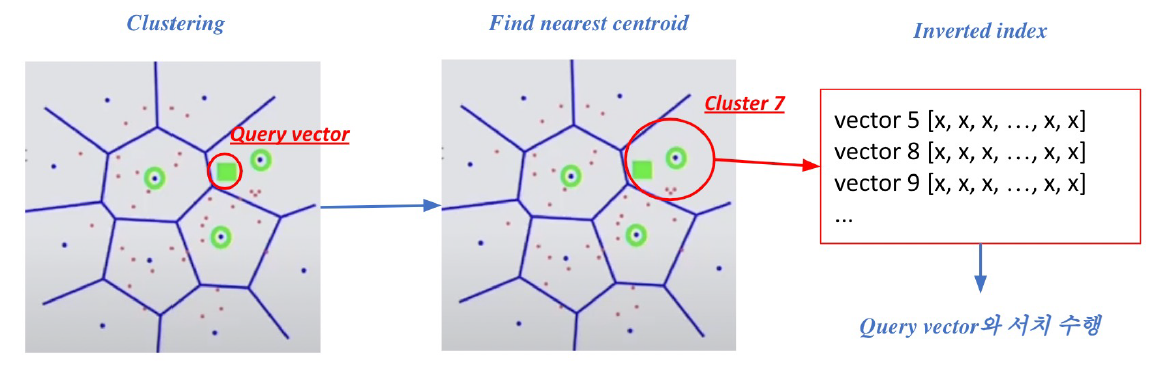

In [41]:
patch_core.anomaly_scorer.detection_features = patch_core.anomaly_scorer.feature_merger.merge([features])

In [42]:
patch_core.anomaly_scorer.nn_method.search_index = patch_core.anomaly_scorer.nn_method._create_index(
    dimension = patch_core.anomaly_scorer.detection_features.shape[-1]
)

In [44]:
patch_core.anomaly_scorer.nn_method._train(
    patch_core.anomaly_scorer.nn_method.search_index,
    patch_core.anomaly_scorer.detection_features
)

In [46]:
patch_core.anomaly_scorer.nn_method.search_index.add(
    patch_core.anomaly_scorer.detection_features
)

## 1 ~ 6. Fitting

In [48]:
patch_core.fit(train_dataloader)


Computing support features...:  91%|█████████▏| 96/105 [00:02<00:00, 50.49it/s]
                                                                               

# Prediction

In [51]:
batch_test = next(iter(test_dataloader))

In [67]:
images = batch_test['image']
labels_gt = batch_test['is_anomaly'].numpy().tolist()
masks_gt = batch_test['mask'].numpy().tolist()

images = images.to(torch.float).to(patch_core.device)
_ = patch_core.forward_modules.eval()

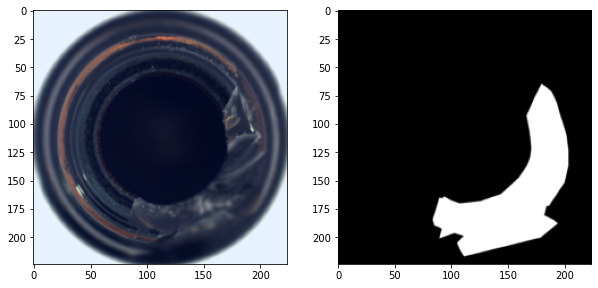

In [66]:
img = images[0].permute(1,2,0)
img = (img - img.min()) / (img.max() - img.min())
mask = np.array(masks_gt)[0].reshape(224,224)

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(img)
ax[1].imshow(mask, cmap='gray')

In [49]:

aggregator = {"scores": [], "segmentations": []}

## 1. Extract Features > Patchfying > Aggregation

In [68]:
features, patch_shapes = patch_core._embed(images, provide_patch_shapes=True)
features = np.asarray(features)

In [71]:
print('features.shape: ',features.shape)

features.shape:  (98, 1024)


## 2. Search Neighbour

In [74]:
query_features = patch_core.anomaly_scorer.feature_merger.merge(
    [features],
)

# query_distances: query와의 거리
# query_nns: 이웃 index
query_distances, query_nns = patch_core.anomaly_scorer.imagelevel_nn(query_features)

In [79]:
print('query_distances.shape: ',query_distances.shape)
print('query_nns.shape: ',query_nns.shape)

query_distances.shape:  (98, 1)
query_nns.shape:  (98, 1)


## 3. Anomaly Score

In [108]:
patch_scores = image_scores = np.mean(query_distances, axis=-1)

In [109]:
print('patch_scores.shape: ',patch_scores.shape)
print('image_scores.shape: ',image_scores.shape)

patch_scores.shape:  (98,)
image_scores.shape:  (98,)


### Image Score

In [110]:
batchsize = images.shape[0]

image_scores = patch_core.patch_maker.unpatch_scores(
    image_scores, batchsize = batchsize
)

In [111]:
print("image_scores.shape: ",image_scores.shape)

image_scores.shape:  (2, 49)


In [112]:
image_scores = image_scores.reshape(*image_scores.shape[:2], -1)

# maximum patch score를 image score로 계산
image_scores = patch_core.patch_maker.score(image_scores)

In [113]:
print("image_scores.shape: ",image_scores.shape)

image_scores.shape:  (2,)


In [114]:
image_scores

array([130.06354, 127.37933], dtype=float32)

### Patch Score

In [115]:
patch_scores = patch_core.patch_maker.unpatch_scores(
    patch_scores, batchsize=batchsize
)

scales = patch_shapes[0]
patch_scores = patch_scores.reshape(batchsize, scales[0], scales[1])

In [118]:
print("patch_scores.shape: ",patch_scores.shape)

patch_scores.shape:  (2, 7, 7)


In [119]:
masks = patch_core.anomaly_segmentor.convert_to_segmentation(patch_scores)

In [123]:
print('len(masks): ',len(masks))
print('masks[0].shape: ',masks[0].shape)

len(masks):  2
masks[0].shape:  (224, 224)


Text(0.5, 1.0, 'predicted mask')

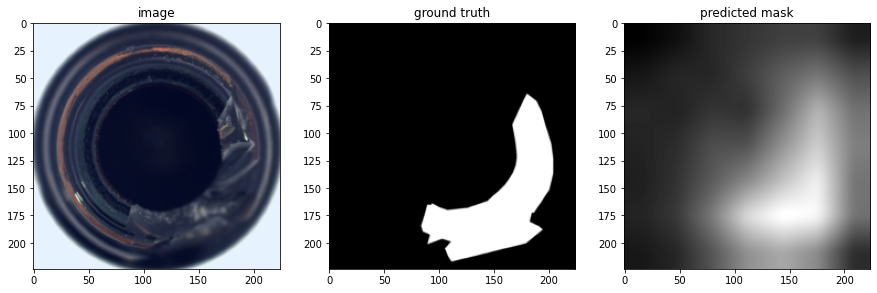

In [129]:
img = images[0].permute(1,2,0).detach().cpu()
img = (img - img.min()) / (img.max() - img.min())
mask = np.array(masks_gt)[0].reshape(224,224)

fig, ax = plt.subplots(1,3,figsize=(15,10))
ax[0].imshow(img)
ax[0].set_title('image')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title('ground truth')
ax[2].imshow(masks[0], cmap='gray')
ax[2].set_title('predicted mask')

## 1 ~ 3. prediction

In [138]:
scores, segmentations, labels_gt, masks_gt = patch_core.predict(
    test_dataloader
)

# Evaluation

In [139]:
# score scaling
scores = np.array(scores)
min_scores = scores.min(axis=-1).reshape(-1, 1)
max_scores = scores.max(axis=-1).reshape(-1, 1)
scores = (scores - min_scores) / (max_scores - min_scores)
scores = np.mean(scores, axis=0)

In [145]:
# segmentation scaling
segmentations = np.array(segmentations)
min_scores = (
    segmentations.reshape(len(segmentations), -1)
    .min(axis=-1)
    .reshape(-1, 1, 1, 1)
)
max_scores = (
    segmentations.reshape(len(segmentations), -1)
    .max(axis=-1)
    .reshape(-1, 1, 1, 1)
)
segmentations = (segmentations - min_scores) / (max_scores - min_scores)
segmentations = np.mean(segmentations, axis=0)

In [146]:
anomaly_labels = [
    x[1] != "good" for x in test_dataloader.dataset.data_to_iterate
]

## 1. segmentation images

In [151]:
image_paths = [
    x[2] for x in test_dataloader.dataset.data_to_iterate
]
mask_paths = [
    x[3] for x in test_dataloader.dataset.data_to_iterate
]

def image_transform(image):
    in_std = np.array(
        IMAGENET_STD
    ).reshape(-1, 1, 1)
    in_mean = np.array(
        IMAGENET_MEAN
    ).reshape(-1, 1, 1)
    image = test_dataloader.dataset.transform_img(image)
    return np.clip(
        (image.numpy() * in_std + in_mean) * 255, 0, 255
    ).astype(np.uint8)

def mask_transform(mask):
    return test_dataloader.dataset.transform_mask(mask).numpy()

image_save_path = os.path.join(
    './figures', "segmentation_images", "bottle"
)
os.makedirs(image_save_path, exist_ok=True)

utils.plot_segmentation_images(
    image_save_path,
    image_paths,
    segmentations,
    scores,
    mask_paths,
    image_transform=image_transform,
    mask_transform=mask_transform,
)

In [152]:
auroc = metrics.compute_imagewise_retrieval_metrics(
    scores, anomaly_labels
)["auroc"]

# Compute PRO score & PW Auroc for all images
pixel_scores = metrics.compute_pixelwise_retrieval_metrics(
    segmentations, masks_gt
)
full_pixel_auroc = pixel_scores["auroc"]

# Compute PRO score & PW Auroc only images with anomalies
sel_idxs = []
for i in range(len(masks_gt)):
    if np.sum(masks_gt[i]) > 0:
        sel_idxs.append(i)
        
pixel_scores = metrics.compute_pixelwise_retrieval_metrics(
    [segmentations[i] for i in sel_idxs],
    [masks_gt[i] for i in sel_idxs],
)
anomaly_pixel_auroc = pixel_scores["auroc"]

In [155]:
print('Detection AUROC: ',auroc)
print('Segmentation AUROC: ',full_pixel_auroc)
print('Segmentation AUROC of abnormal images: ',anomaly_pixel_auroc)

Detection AUROC:  0.9896825396825397
Segmentation AUROC:  0.9296072883049693
Segmentation AUROC of abnormal images:  0.9052426897919814
